## Importing libraries

In [448]:
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
#import emoji 
from collections import Counter 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

import warnings
warnings.filterwarnings('ignore')

### Extracting date time, contact-name, and message from the chat logs

In [449]:
def date_time(s):
    pattern = '^([0-9]+(\/)([0-9]+)(\/)[0-9]+, ([0-9]+):([0-9]+)\s(PM|AM|am|pm) - )'
    result = re.match(pattern, s)
    if result:
        return True 
    return False

def contact(s):
    s=s.split(":")
    if len(s) == 2:
        return True 
    return False

def getmsg(line):
    splitline = line.split(' - ')
    date, time = splitline[0].split(', ')
    msg = " ".join(splitline[1:])
   
    if contact(msg):
        split_msg = msg.split(': ')
        author = split_msg[0]
        msg = " ".join(split_msg[1:])
    else:
        author = None
    return date, time, author, msg


In [450]:
data = []
conversation = 'chats/WhatsApp Chat with Vishal Sir.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    msgBuffer = []
    date, time, author=None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()

        if date_time(line):
            if len(msgBuffer) > 0 :
                data.append([date, time, author, " ".join(msgBuffer)])
            msgBuffer.clear()
            date, time, author, msg = getmsg(line)
            msgBuffer.append(msg)
        else:
            msgBuffer.append(line)

In [451]:
msgBuffer

['It’s ok sir', 'Any time']

### Converting the extracted data into DataFrame

In [452]:
data = pd.DataFrame(data, columns=["Date", "Time", "Contact", "Message"])
data['Date'] = pd.to_datetime(data['Date'])
data = data.dropna()
data

,Date,Time,Contact,Message
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too
1,2021-03-31,7:47 PM,Sai Nithin Kadarla,<Media omitted>
2,2021-04-07,5:59 PM,Sai Nithin Kadarla,You deleted this message
3,2021-04-07,5:59 PM,Sai Nithin Kadarla,<Media omitted>
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it
...,...,...,...,...
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir
130,2024-05-30,11:58 AM,Sai Nithin Kadarla,<Media omitted>
131,2024-05-30,11:59 AM,Sai Nithin Kadarla,<Media omitted>
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir


## Cleaning the Data

In [453]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

### Cleaning the deleted messages and media ommitio logs


In [454]:
data["Message"] = data['Message'][data["Message"] != "<Media omitted>"]
data.dropna(axis=0, inplace=True)

string_to_match = " deleted this message"
data = data[~data["Message"].str.contains(string_to_match, case=False)]
data


,Date,Time,Contact,Message
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it
5,2021-05-05,9:37 PM,Sai Nithin Kadarla,"Sir , is online classes going on ?"
6,2021-06-30,2:35 PM,Sai Nithin Kadarla,Thank you sir
14,2021-12-03,4:35 PM,Sai Nithin Kadarla,Ok sir
...,...,...,...,...
127,2024-05-30,11:56 AM,Vishal Sir,S
128,2024-05-30,11:56 AM,Vishal Sir,Send ou also
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir


### Cleaning the messages from punctuations and stopwords and tokenized the messages

In [455]:
data['Cleaned_message'] = data["Message"].apply(lambda x: x.lower().translate(str.maketrans(' ', " ", string.punctuation)))

data['Tokenized_words'] = data["Cleaned_message"].apply(lambda y: [word for word in word_tokenize(y) if word not in STOPWORDS and word not in stop_words] )

In [456]:
data

,Date,Time,Contact,Message,Cleaned_message,Tokenized_words
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too,sir this too,[sir]
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it,sir i did it,[sir]
5,2021-05-05,9:37 PM,Sai Nithin Kadarla,"Sir , is online classes going on ?",sir is online classes going on,"[sir, online, classes, going]"
6,2021-06-30,2:35 PM,Sai Nithin Kadarla,Thank you sir,thank you sir,"[thank, sir]"
14,2021-12-03,4:35 PM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]"
...,...,...,...,...,...,...
127,2024-05-30,11:56 AM,Vishal Sir,S,s,[]
128,2024-05-30,11:56 AM,Vishal Sir,Send ou also,send ou also,"[send, ou]"
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]"
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir,ou certificate sir,"[ou, certificate, sir]"


### Applying the lemmatization techniques

In [457]:
lemmatizer = WordNetLemmatizer()
data["Lemmatized"] = [[lemmatizer.lemmatize(token) for token in token_list] for token_list in data["Tokenized_words"]]


## Sentiment analysis

### Sentiments of each message

In [458]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

data['Positive'] = [sentiments.polarity_scores(i)['pos'] for i in data["Message"]]
data['Negative'] = [sentiments.polarity_scores(i)['neg'] for i in data["Message"]]
data['Neutral'] = [sentiments.polarity_scores(i)['neu'] for i in data["Message"]]

### Normalizing the values of the sentiment Analyzer

In [459]:
data["Positive"] = data["Positive"].apply(lambda x: np.ceil(x) if x - np.floor(x) >= 0.5 else np.floor(x))
data["Negative"] = data["Negative"].apply(lambda x: np.ceil(x) if x - np.floor(x) >= 0.5 else np.floor(x))
data["Neutral"] = data["Neutral"].apply(lambda x: np.ceil(x) if x - np.floor(x) >= 0.5 else np.floor(x))


In [460]:
data

,Date,Time,Contact,Message,Cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too,sir this too,[sir],[sir],0.0,0.0,1.0
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it,sir i did it,[sir],[sir],0.0,0.0,1.0
5,2021-05-05,9:37 PM,Sai Nithin Kadarla,"Sir , is online classes going on ?",sir is online classes going on,"[sir, online, classes, going]","[sir, online, class, going]",0.0,0.0,1.0
6,2021-06-30,2:35 PM,Sai Nithin Kadarla,Thank you sir,thank you sir,"[thank, sir]","[thank, sir]",1.0,0.0,0.0
14,2021-12-03,4:35 PM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
127,2024-05-30,11:56 AM,Vishal Sir,S,s,[],[],0.0,0.0,0.0
128,2024-05-30,11:56 AM,Vishal Sir,Send ou also,send ou also,"[send, ou]","[send, ou]",0.0,0.0,1.0
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir,ou certificate sir,"[ou, certificate, sir]","[ou, certificate, sir]",0.0,0.0,1.0


### Over all sentiment of the chat

In [461]:
pos = sum(data['Positive'])
neg = sum(data['Negative'])
neu = sum(data['Neutral'])

def score(a,b,c):
    if a>b and a>c:
        print('postive')
    elif b>a and b>c:
        print('negative')
    else:
        print("neutral")

score(pos, neg, neu)

pos, neg, neu

neutral


(23.0, 0.0, 59.0)

### Added the sentiment in text form

In [462]:
def compare_values(row):
    if row['Positive'] > row['Negative'] and row['Positive'] > row['Neutral']:
        return 'positive'
    elif row['Negative'] > row['Positive'] and row['Negative'] > row['Neutral']:
        return 'negative'
    else:
        return 'neutral'

In [463]:
data["sentiment"] = data.apply(compare_values, axis = 1)
data

,Date,Time,Contact,Message,Cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too,sir this too,[sir],[sir],0.0,0.0,1.0,neutral
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it,sir i did it,[sir],[sir],0.0,0.0,1.0,neutral
5,2021-05-05,9:37 PM,Sai Nithin Kadarla,"Sir , is online classes going on ?",sir is online classes going on,"[sir, online, classes, going]","[sir, online, class, going]",0.0,0.0,1.0,neutral
6,2021-06-30,2:35 PM,Sai Nithin Kadarla,Thank you sir,thank you sir,"[thank, sir]","[thank, sir]",1.0,0.0,0.0,positive
14,2021-12-03,4:35 PM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive
...,...,...,...,...,...,...,...,...,...,...,...
127,2024-05-30,11:56 AM,Vishal Sir,S,s,[],[],0.0,0.0,0.0,neutral
128,2024-05-30,11:56 AM,Vishal Sir,Send ou also,send ou also,"[send, ou]","[send, ou]",0.0,0.0,1.0,neutral
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir,ou certificate sir,"[ou, certificate, sir]","[ou, certificate, sir]",0.0,0.0,1.0,neutral


### Extracting the sentiment trends into seperate dataframe

In [464]:
grouped = data.groupby('Date')

def most_common_sentiment(series):
    return Counter(series).most_common(1)[0][0]

# Create a new DataFrame with the required columns
sentiment_logs = grouped.agg(
    start_sentiment=('sentiment', 'first'),
    end_sentiment=('sentiment', 'last'),
    most_common_sentiment=('sentiment', most_common_sentiment)
).reset_index()

# Print the result DataFrame
print(sentiment_logs)

         Date start_sentiment end_sentiment most_common_sentiment
0  2021-03-31         neutral       neutral               neutral
1  2021-04-07         neutral       neutral               neutral
2  2021-05-05         neutral       neutral               neutral
3  2021-06-30        positive      positive              positive
4  2021-12-03        positive      positive              positive
5  2021-12-27         neutral      positive               neutral
6  2022-01-12         neutral       neutral               neutral
7  2022-01-13         neutral       neutral               neutral
8  2022-01-20         neutral       neutral               neutral
9  2022-01-21         neutral       neutral               neutral
10 2022-04-14        positive      positive              positive
11 2022-04-29         neutral      positive              positive
12 2022-04-30         neutral       neutral               neutral
13 2022-05-07        positive      positive              positive
14 2022-08

### Extracted sentiment at start and end of the conversation

In [465]:
grouped = data.groupby('Date')

# Add columns for the first and last Sentiment values within each group
data['Start Conversation'] = grouped['sentiment'].transform('first')
data['Stop Conversation'] = grouped['sentiment'].transform('last')
data

,Date,Time,Contact,Message,Cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment,Start Conversation,Stop Conversation
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too,sir this too,[sir],[sir],0.0,0.0,1.0,neutral,neutral,neutral
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it,sir i did it,[sir],[sir],0.0,0.0,1.0,neutral,neutral,neutral
5,2021-05-05,9:37 PM,Sai Nithin Kadarla,"Sir , is online classes going on ?",sir is online classes going on,"[sir, online, classes, going]","[sir, online, class, going]",0.0,0.0,1.0,neutral,neutral,neutral
6,2021-06-30,2:35 PM,Sai Nithin Kadarla,Thank you sir,thank you sir,"[thank, sir]","[thank, sir]",1.0,0.0,0.0,positive,positive,positive
14,2021-12-03,4:35 PM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2024-05-30,11:56 AM,Vishal Sir,S,s,[],[],0.0,0.0,0.0,neutral,neutral,positive
128,2024-05-30,11:56 AM,Vishal Sir,Send ou also,send ou also,"[send, ou]","[send, ou]",0.0,0.0,1.0,neutral,neutral,positive
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive,neutral,positive
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir,ou certificate sir,"[ou, certificate, sir]","[ou, certificate, sir]",0.0,0.0,1.0,neutral,neutral,positive


## Analysing the word frequencies

### Frequency of each word

In [466]:
combined_words = [word for sublist in data['Lemmatized'] for word in sublist]

fdist = nltk.FreqDist(combined_words)

### Most common words

In [467]:
print("The most common 10 words are: \n")

for i,j in fdist.most_common(10):
    print(i, end=", ")

The most common 10 words are: 

sir, ok, thank, send, please, certificate, one, name, call, good, 


## Topic modeling

In [468]:
data["Tokenized_mgs"] = data["Tokenized_words"].apply(lambda x: " ".join(x))
data

,Date,Time,Contact,Message,Cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment,Start Conversation,Stop Conversation,Tokenized_mgs
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too,sir this too,[sir],[sir],0.0,0.0,1.0,neutral,neutral,neutral,sir
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it,sir i did it,[sir],[sir],0.0,0.0,1.0,neutral,neutral,neutral,sir
5,2021-05-05,9:37 PM,Sai Nithin Kadarla,"Sir , is online classes going on ?",sir is online classes going on,"[sir, online, classes, going]","[sir, online, class, going]",0.0,0.0,1.0,neutral,neutral,neutral,sir online classes going
6,2021-06-30,2:35 PM,Sai Nithin Kadarla,Thank you sir,thank you sir,"[thank, sir]","[thank, sir]",1.0,0.0,0.0,positive,positive,positive,thank sir
14,2021-12-03,4:35 PM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive,positive,positive,ok sir
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2024-05-30,11:56 AM,Vishal Sir,S,s,[],[],0.0,0.0,0.0,neutral,neutral,positive,
128,2024-05-30,11:56 AM,Vishal Sir,Send ou also,send ou also,"[send, ou]","[send, ou]",0.0,0.0,1.0,neutral,neutral,positive,send ou
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive,neutral,positive,ok sir
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir,ou certificate sir,"[ou, certificate, sir]","[ou, certificate, sir]",0.0,0.0,1.0,neutral,neutral,positive,ou certificate sir


In [469]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Tokenized_mgs'])


lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(X)


def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda_model, vectorizer)


topic_distribution = lda_model.transform(X)


def most_relevant(topic_distribution):
    most_relevant_topics = []
    for distribution in topic_distribution:
        most_relevant_topic = distribution.argmax()
        most_relevant_topics.append(most_relevant_topic)

    return most_relevant_topics

relevant_topics = most_relevant(topic_distribution)


data['LDA'] = relevant_topics


Topic 0:
['sir', 'ok', 'thank', 'call', 'one', 'certificate', 'ki', 'please', 'daddy', 'cse']
Topic 1:
['name', 'engineering', 'service', 'nithin', 'paper', 'university', 'microsoft', 'computer', 'science', 'cloud']
Topic 2:
['father', 'number', 'ur', 'congratulations', 'heros', 'wonderful', 'todays', 'send', 'sir', '9866266277']
Topic 3:
['using', 'done', 'project', 'ou', 'good', 'pi', 'smart', 'modules', 'automative', 'microcontrollers']
Topic 4:
['send', 'please', 'jntu', 'certificate', 'srujan', 'photo', 'nithin', 'cleaner', 'pic', 'urs']


In [470]:
topic_distribution[5].argmax()

4

In [471]:
data

,Date,Time,Contact,Message,Cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment,Start Conversation,Stop Conversation,Tokenized_mgs,LDA
0,2021-03-31,7:44 PM,Sai Nithin Kadarla,Sir this too,sir this too,[sir],[sir],0.0,0.0,1.0,neutral,neutral,neutral,sir,0
4,2021-04-07,5:59 PM,Sai Nithin Kadarla,sir i did it,sir i did it,[sir],[sir],0.0,0.0,1.0,neutral,neutral,neutral,sir,0
5,2021-05-05,9:37 PM,Sai Nithin Kadarla,"Sir , is online classes going on ?",sir is online classes going on,"[sir, online, classes, going]","[sir, online, class, going]",0.0,0.0,1.0,neutral,neutral,neutral,sir online classes going,1
6,2021-06-30,2:35 PM,Sai Nithin Kadarla,Thank you sir,thank you sir,"[thank, sir]","[thank, sir]",1.0,0.0,0.0,positive,positive,positive,thank sir,0
14,2021-12-03,4:35 PM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive,positive,positive,ok sir,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2024-05-30,11:56 AM,Vishal Sir,S,s,[],[],0.0,0.0,0.0,neutral,neutral,positive,,0
128,2024-05-30,11:56 AM,Vishal Sir,Send ou also,send ou also,"[send, ou]","[send, ou]",0.0,0.0,1.0,neutral,neutral,positive,send ou,4
129,2024-05-30,11:56 AM,Sai Nithin Kadarla,Ok sir,ok sir,"[ok, sir]","[ok, sir]",1.0,0.0,0.0,positive,neutral,positive,ok sir,0
132,2024-05-30,11:59 AM,Sai Nithin Kadarla,Ou certificate sir,ou certificate sir,"[ou, certificate, sir]","[ou, certificate, sir]",0.0,0.0,1.0,neutral,neutral,positive,ou certificate sir,0



## Visualizations

### Generating word clouds from the frequencies of each word

In [472]:
wordcloud = WordCloud().generate_from_frequencies(fdist)

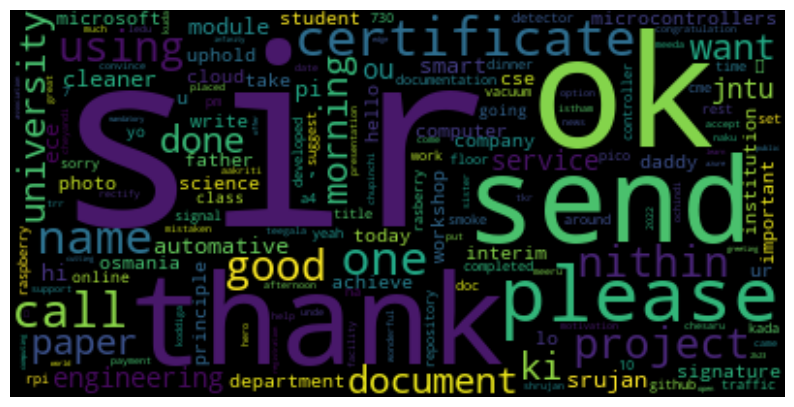

In [473]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axis
plt.show()
